This is based off of someones code to analysis music type

#https://github.com/Harbim001/Analysing_Nigerian_Music_Growth_Globally/blob/main/analysing_nigerian_music_growth_globally%20(1).py


In [531]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D,ConvLSTM1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

import pickle

import pandas as pd
from pathlib import Path

path_to_dictionary_all_50 = "/Users/cslinxs/Desktop/all_weeks/summer24-lab/measurements_auscultatory_dictionary_ALL.pkl"

# Getting the Pikel file has the 50 point segmented
with open(path_to_dictionary_all_50, 'rb') as handle:
    all_auscultatory_50_segmented = pickle.load(handle)

# Some lists are filled with nans would be better to remove them
auscultatory_keys_with_nulls = []
for key, each_grouping in all_auscultatory_50_segmented.items():
    if True in list(np.isnan(each_grouping[0])):
        auscultatory_keys_with_nulls.append(key)
for key in auscultatory_keys_with_nulls:
    del all_auscultatory_50_segmented[key]


# Grouping people by their person ID
auscultatory_data_grouped_by_pid = {}
for key, each_grouping in list(all_auscultatory_50_segmented.items()):
    person_id = key.split("_")[1].split("/")[1]
    if not(person_id in auscultatory_data_grouped_by_pid):
        auscultatory_data_grouped_by_pid[person_id] = []
    auscultatory_data_grouped_by_pid[person_id].append({key: each_grouping})
         


First im going to split ppl if they have hyper tension or not

In [532]:
# This gets the person
path_aurora_dataset = Path('/Users/cslinxs/Desktop/aurora_dataset/aurora_dataset/')

# This is getting the PID of ppl with Hypertenstion
participants_data =  path_aurora_dataset / "participants.tsv"
participants_csv_data = pd.read_csv(participants_data,sep = '\t')
participants_csv_htn = participants_csv_data[participants_csv_data["self_report_htn"].isin(["managed","unmanaged"])]
participants_csv_htn = participants_csv_htn[participants_csv_htn["pid"].str.contains('a')]
people_htn = participants_csv_htn["pid"]
people_htn

keys_for_grouping = [
"Calibration_start",#0
"Static_challenge_start",#1
"Seated_calibration",#2
"Static_seated_challenge",#3
"Exercise_challenge_start",#4
"Temporal_challenge_start",#5
"Temporal_seated_challenge"]#6
current_activity_key_used  = 0

 
def get_person_data(PID):
    return ([([each_data[0] for each_data in item.values()]) for item in auscultatory_data_grouped_by_pid[PID]], [([each_data[1] for each_data in item.values()][0]) for item in auscultatory_data_grouped_by_pid[PID]], [item.keys() for item in auscultatory_data_grouped_by_pid[PID]])

# This groups people by a feature
def get_person_data_group(diction, identifier):
    return ([([each_data[0] for each_data in item.values()]) for item in diction[identifier]], [([each_data[1] for each_data in item.values()][0]) for item in diction[identifier]], [item.keys() for item in diction[identifier]])

def get_person_split_data(dictionary_with_people):
    return ([item[0] for item in dictionary_with_people],[item[1] for item in dictionary_with_people],[item[2] for item in dictionary_with_people])

def get_people_with_hypertenstion():
    hyperstion_people = []
    non_hypertension_people = []
    all_people_charts = []
    for key, each_grouping in list(all_auscultatory_50_segmented.items()):

        if keys_for_grouping[current_activity_key_used] in key:

            person_id = key.split("_")[1].split("/")[1]
            if person_id in list(people_htn):
                hyperstion_people.append(each_grouping)
            else:
                non_hypertension_people.append(each_grouping)
            all_people_charts.append(each_grouping)
            
    return (hyperstion_people, non_hypertension_people, all_people_charts)


In [533]:
people_with_hypertenstion = get_people_with_hypertenstion()[0]
people_with_out_hypertenstion = get_people_with_hypertenstion()[1]
all_people_data = get_people_with_hypertenstion()[2]

X = get_person_split_data(all_people_data)[0]
y = np.array(get_person_split_data(all_people_data)[1])


X1 = get_person_split_data(people_with_out_hypertenstion)[0]
y1 = np.array(get_person_split_data(people_with_out_hypertenstion)[1])


In [534]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# print(X.shape)

In [535]:
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)
# y = to_categorical(y)

In [536]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y_train.shape)

(1592, 1)


In [537]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)


In [541]:
def create_model():


    model = Sequential()
   
    # model.add(Conv1D(1, kernel_size=10, strides=10, activation='relu' ))
    # model.add(Conv1D(1, kernel_size=5, activation='relu'))


    model.add(Conv1D(1, kernel_size=2, strides=2, activation='relu',use_bias=False ))
    model.add(Conv1D(1, kernel_size=5, strides=5, activation='relu',use_bias=False))

    # model.add(Conv1D(1, kernel_size=3, activation='relu'))
    # model.add(Conv1D(1, kernel_size=2, activation='relu'))
    # model.add(Conv1D(1, kernel_size=2, activation='relu'))
   


    # model.add(GlobalMaxPooling1D())
    # # model.add(Dense(2, activation='relu'))
    # model.add(Dropout(0.5))

    # model.add(Dropout(0.5))
    # # model.add(MaxPooling1D(pool_size=2))
    # # # model.add(Flatten())
    # model.add(Dense(1, activation='relu'))
    
    # model.add(Dense(y_train.shape[1], activation='softmax'))
    #model.add(Dense(181, activation='softmax'))
    # model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    optimizer = RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])

    return model



In [542]:
model = create_model()
history = model.fit(X_train, y_train, epochs=50, validation_split=0.3)
model.summary()
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/50


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16583.3730 - mae: 127.4116 - val_loss: 16542.2695 - val_mae: 127.4153
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 16439.1543 - mae: 126.9134 - val_loss: 16542.2695 - val_mae: 127.4153
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 16525.4980 - mae: 127.2866 - val_loss: 16542.2695 - val_mae: 127.4153
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 16480.9531 - mae: 127.0907 - val_loss: 16542.2695 - val_mae: 127.4153
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 16872.9180 - mae: 128.5823 - val_loss: 16542.2695 - val_mae: 127.4153
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 16642.3770 - mae: 127.6364 - val_loss: 16542.2695 - val_mae: 127.4153
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 16630.7324 - mae: 127.5123 - val_loss: 16542.2695 - val_mae: 127.4153
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 16610.7734 - mae: 127.5383 - val_loss: 1654

Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_318 (Conv1D)             │ (None, 25, 1)          │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_319 (Conv1D)             │ (None, 5, 1)           │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16 (68.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9 (40.00 B)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 16501.7910 - mae: 127.1715
Test accuracy: 127.75814819335938


In [540]:
print(y_train.shape)

(1592, 1)


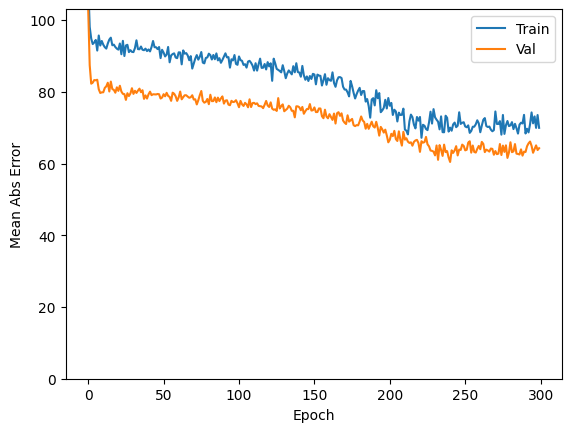

In [ ]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mae']), 
           label='Train')
  plt.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val')
  plt.legend()
  plt.ylim([0,max(history.history['val_mae'])])
plot_history(history)

In [453]:
model.summary()

Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_273 (Conv1D)             │ (None, 49, 1)          │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_274 (Conv1D)             │ (None, 9, 1)           │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_81         │ (None, 1)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20 (84.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11 (48.00 B)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
[88. 88. 88. ... 88. 88. 88.]


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


Text(223.7, 81.55, 'r2 -4.45')

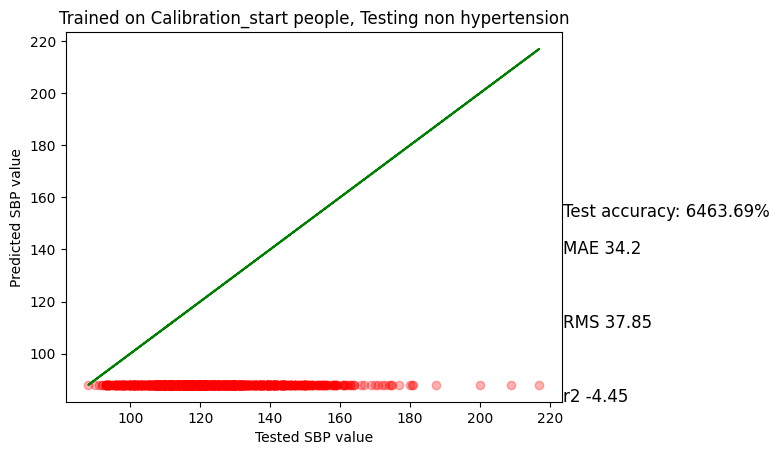

In [488]:
# Standardize the feature data using the same scaler used for the training data
X1 = get_person_split_data(people_with_out_hypertenstion)[0]
y1 = get_person_split_data(people_with_out_hypertenstion)[1]

X_new = scaler.transform(X1)

# Reshape the input data for 1D CNN
X_new = np.expand_dims(X_new, axis=2)

# Predict the probabilities for each genre
predictions = model.predict(X_new)

# Get the genre index with the highest probability for each sample
predicted_indices = np.argmax(predictions, axis=1)

# Decode the genre indices to genre names
predicted_genres = label_encoder.inverse_transform(predicted_indices)

# Add the predicted genres to the new dataset
print(predicted_genres)
plt.plot(y1,y1, color="green")
plt.scatter(y1, predicted_genres,  alpha=0.3 , color="red")

# plt.title(f"Trained on people WITH hyptenstion, Testing WITH hypertension")
plt.title(f"Trained on {keys_for_grouping[current_activity_key_used]} people, Testing non hypertension")#, test_accuracy: {round(test_accuracy*100,2)}%")

plt.xlabel("Tested SBP value")
plt.ylabel("Predicted SBP value")

xmin, xmax, ymin, ymax = plt.axis()
plt.text(xmax+0.25, ymin+(ymax-ymin)*0.5,s=f"Test accuracy: {round(test_accuracy*100,2)}%", fontsize=12)

plt.text(xmax+0.25, ymin+(ymax-ymin)*0.4,s=f"MAE {round(mean_absolute_error(y1, predicted_genres),2)}", fontsize=12)
plt.text(xmax+0.25, ymin+(ymax-ymin)*0.2, s= f"RMS {round(root_mean_squared_error(y1, predicted_genres),2)}", fontsize=12)
plt.text(xmax+0.25, ymin, s= f"r2 {round(r2_score(y1, predicted_genres),2)}", fontsize=12)

In [489]:
# people_with_out_hypertenstion = get_people_with_hypertenstion()[1]

# # for now I will only test on people with hyptertension
# X1 = get_person_split_data(people_with_out_hypertenstion)[0]
# y1 = get_person_split_data(people_with_out_hypertenstion)[1]


In [261]:
# I want a list
# of ppl with both hypertension and non
# then i want a list of the combo.
# maybe i can remove some of the hyper tensiton both and non bottom ato make a new list!!!